<a href="https://colab.research.google.com/github/sacontreras/dsc-mod-4-project-v2-1-online-ds-sp-000/blob/master/mod4-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download images if we haven't already...

In [1]:
import tensorflow as tf
import urllib
import urllib.request
from tqdm.auto import tqdm
import numpy as np
import os
import zipfile

def download(url, local_fname, block_sz=8192):
  http_file = urllib.request.urlopen(url)
  if http_file.getcode() != 200:
      raise ValueError(f"ERROR {http_file.getcode()} while opening {url}.")

  meta = http_file.info()
  file_size = int(meta['Content-Length'])
  print(f"Downloading {url} (filesize: {file_size} bytes) to {local_fname}...")
  print()

  f = None
  try:
    f = open(local_fname, 'wb')
    file_size_dl = 0
    fblocks = np.arange(start=0, stop=file_size+1, step=block_sz)
    tqdm_pb = tqdm(fblocks)
    for tfblock in tqdm_pb: 
        buffer = http_file.read(block_sz)
        if not buffer:
            break
        file_size_dl += len(buffer)
        f.write(buffer)
  finally:
    if f is not None:
      f.close()

  file_size_local = os.path.getsize(f.name)
  if file_size_local != file_size:
      raise ValueError(f"URL file {url} is {file_size} bytes but we only downloaded {file_size_local} bytes to local file {local_fname}.")
  else:
      print(f"Successfully downloaded {file_size_local}/{file_size} bytes from URL file {url} to local file {local_fname}!")
  return 0




# two different "current" dataset URLs:
# 1. https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip
# 2. https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded
images_download_URL = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip'

root_dir = './'
images_root = os.path.join(root_dir, 'CellData')

if not os.path.isdir(images_root):
  local_archive_fname = 'mod-4-images.zip'
  images_archive = os.path.join(root_dir, local_archive_fname)

  download(images_download_URL, images_archive, block_sz=1024**2)

  images_archive_2 = os.path.join(root_dir, "ZhangLabData.zip")
  print(f"unzipping {images_archive} to {images_archive_2}...")
  zip_ref = zipfile.ZipFile(images_archive, 'r')
  zip_ref.extractall(root_dir) # this will unzip mod-4-images.zip to another archive: {root_dir}/ZhangLabData.zip
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive}...")
  os.remove(images_archive)
  print(f"\tDONE")

  # now unzip ZhangLabData.zip
  print(f"unzipping {images_archive_2} to {images_root}...")
  zip_ref = zipfile.ZipFile(images_archive_2, 'r')
  zip_ref.extractall(root_dir) # this will unzip to: {root_dir}/CellData
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive_2}...")
  os.remove(images_archive_2)
  print(f"\tDONE")
else:
  print(f"{images_root} already exists locally - skipping download")

./CellData already exists locally - skipping download


# Get labeled image pathnames and filter out non-image files...

In [2]:
# the images we are interested in:
#{root_dir}
# |- CellData
#    |- chest_xray
#       |- test
#          |- NORMAL
#          |- PNEUMONIA
#       |- train
#          |- NORMAL
#          |- PNEUMONIA

images_root = os.path.join(images_root, 'chest_xray')

train_dir = os.path.join(images_root, 'train')
test_dir = os.path.join(images_root, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

def list_images(dir):
  return list(filter(lambda fn: fn.endswith('.jpeg') or fn.endswith('.jpg') or fn.endswith('.png'), os.listdir(dir)))

train_normal_fnames = list_images(train_normal_dir)
n_train_normal = len(train_normal_fnames)
print(f'total training NORMAL images: {n_train_normal}')
train_pneumonia_fnames = list_images(train_pneumonia_dir)
n_train_pneumonia = len(train_pneumonia_fnames)
print(f'total training PNEUMONIA images: {n_train_pneumonia}')
n_train = n_train_normal + n_train_pneumonia

test_normal_fnames = list_images(test_normal_dir)
n_test_normal = len(test_normal_fnames)
print(f'total test NORMAL images: {n_test_normal}')
test_pneumonia_fnames = list_images(test_pneumonia_dir)
n_test_pneumonia = len(test_pneumonia_fnames)
print(f'total test PNEUMONIA images: {n_test_pneumonia}')
n_test = n_test_normal + n_test_pneumonia

train_normal_image_paths = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames]
train_pneumonia_image_paths = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames]
test_normal_image_paths = [os.path.join(test_normal_dir, fname) for fname in test_normal_fnames]
test_pneumonia_image_paths = [os.path.join(test_pneumonia_dir, fname) for fname in test_pneumonia_fnames]

total training NORMAL images: 1349
total training PNEUMONIA images: 3883
total test NORMAL images: 234
total test PNEUMONIA images: 390


# Explore the Dataset

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

## Re-run the following cell to see a different set of images

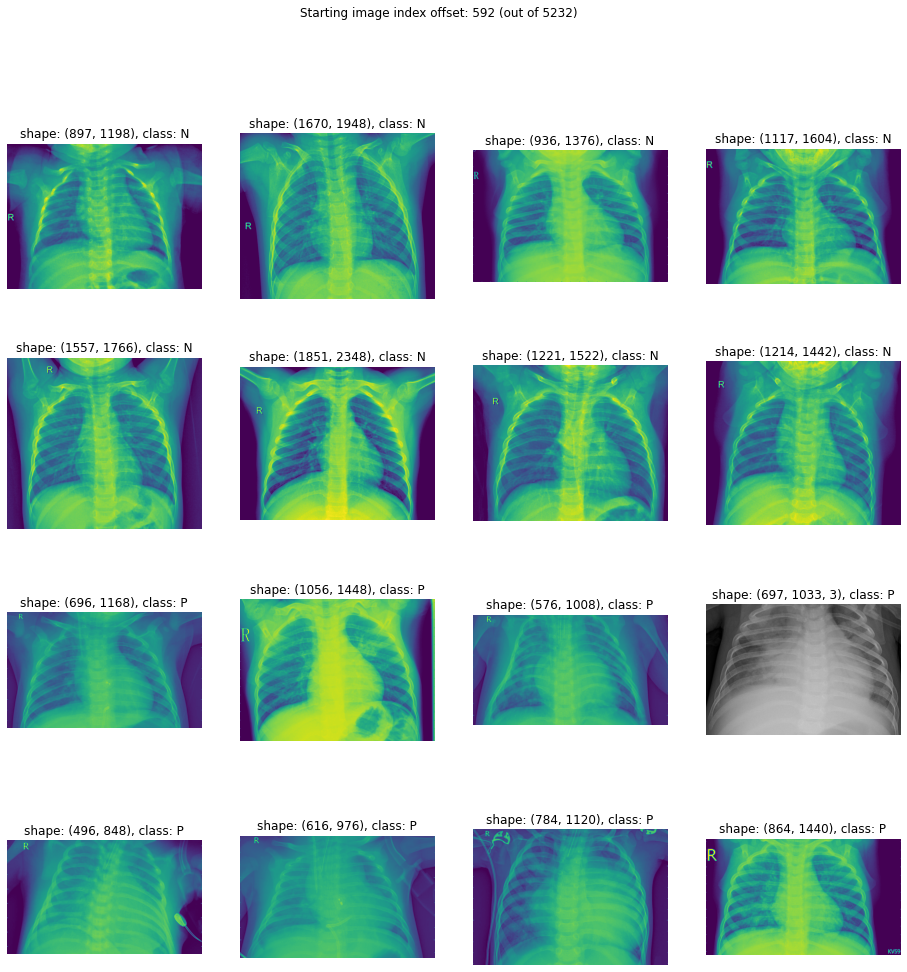

In [4]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index = random.randint(0,int(min(n_train_normal,n_train_pneumonia)/8)-1)*8

next_normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
  plt.suptitle(f"Starting image index offset: {pic_index} (out of {n_train})")
  sp = plt.subplot(nrows, ncols, i+1)
  im = Image.open(img_path)
  im_as_array = np.array(im)
  sp.set_title(f"shape: {im_as_array.shape}, class: {'N' if i<8 else 'P'}")
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Get a feel for the range of all image shapes

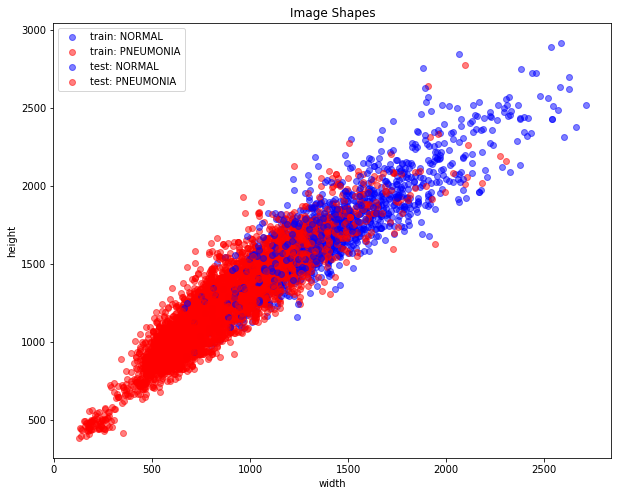

mean shape: (974, 1328)


In [5]:
fig = plt.figure(figsize=(10,8))
plt.title('Image Shapes')
plt.xlabel('width')
plt.ylabel('height')
smallest = None
biggest = None
W_all = []
H_all = []
for i, t_image_paths in enumerate([(train_normal_image_paths, train_pneumonia_image_paths), (test_normal_image_paths, test_pneumonia_image_paths)]):
  for j, img_paths in enumerate(t_image_paths):
    W = []
    H = []
    for img_path in img_paths:
      try:
        im = Image.open(img_path)
        im_as_array = np.array(im)
        w = im_as_array.shape[0]
        W.append(w)
        W_all.append(w)
        h = im_as_array.shape[1]
        H.append(h)
        H_all.append(h)
        n_pixels = w*h
        if smallest == None or n_pixels < smallest[0][0]*smallest[0][1]:
          smallest = ((w,h), img_path)
        if biggest == None or n_pixels > biggest[0][0]*biggest[0][1]:
          biggest = ((w,h), img_path)
      except:
        pass
    plt.scatter(W, H, c='blue' if j==0 else 'red', alpha=0.5, label=f"{'train' if i==0 else 'test'}: NORMAL" if j==0 else f"{'train' if i==0 else 'test'}: PNEUMONIA")
plt.legend()
plt.show()

mean_shape = (int(np.mean(W_all)), int(np.mean(H_all)))
print(f"mean shape: ({mean_shape[0]}, {mean_shape[1]})")

smallest: ((127, 384), './CellData/chest_xray/train/PNEUMONIA/VIRUS-355597-0002.jpeg')


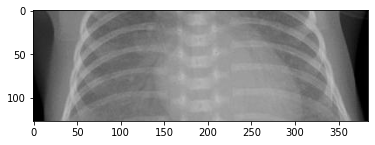

In [6]:
print(f"smallest: {smallest}")
img = mpimg.imread(smallest[1])
plt.imshow(img);

biggest: ((2583, 2916), './CellData/chest_xray/train/NORMAL/NORMAL-9990348-0001.jpeg')


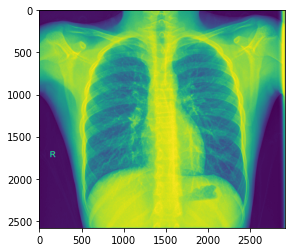

In [7]:
print(f"biggest: {biggest}")
img = mpimg.imread(biggest[1])
plt.imshow(img);

In [8]:
# The mean shape is close to (1024,1024) but this is WAY overkill and causes the NN to greatly overfit
#    and it also takes a VERY long time to train
# I tried halving to (512,512) with very little to no improvement over (1024,1024)
# (300,300) was a big improvement over (512,512)
# But (150,150) is the sweetspot
# input_shape = (150,150)
input_shape = (200,200)

# Use ImageDataGenerator to both augment and stream the set of training images

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255 but, most importantly, we will use data augmentation to simulate a bigger training set
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
train_batch_size = 20
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=train_batch_size, 
    class_mode='binary',
    target_size=input_shape
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.) # obviously we leave the test set untouched by augmentation; however, we do scale it
val_batch_size = 20
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=val_batch_size,
    class_mode='binary',
    target_size=input_shape
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Build the Convolutional Neural Network

The idea is to increasingly become more distinguishing as the CNN magnifies feature "inspection" with each convolution.

In [10]:
dropout_ratio = 0.2

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=8, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        input_shape=(input_shape[0],input_shape[1],3)
    ),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(
        filters=16, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(
        filters=32, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ), 
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ), 
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(
        filters=256, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ), 
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout_ratio), # dropout further reduces overfitting 

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # output
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

In [11]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam

model.compile(
    # optimizer=RMSprop(learning_rate=0.001), 
    optimizer=Adam(learning_rate=0.001),
    # optimizer=Nadam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
)

# Fit the CNN to the training images using the ImageDataGenerators

Recall that the ImageDataGenerator will augment only the training images, not the test images.  We will also stop early if the we reach better than 98% accuracy.

In [12]:
class AccuracyThresholdStopper(tf.keras.callbacks.Callback):
  def __init__(self, accuracy_threshold): # 0 <= accuracy_threshold < 1
    self.accuracy_threshold = accuracy_threshold

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > self.accuracy_threshold:
      print(f"\nReached {self.accuracy_threshold*100}% accuracy so cancelling training!")
      self.model.stop_training = True

history = model.fit(
    train_generator,
    epochs=40,
    # steps_per_epoch=int(n_train/train_batch_size),

    validation_data=validation_generator,
    # validation_steps=int(n_test/val_batch_size),

    callbacks=[AccuracyThresholdStopper(accuracy_threshold=0.98)],

    verbose=1
)

Epoch 1/40
262/262 [==============================] - 105s 400ms/step - loss: 0.4125 - accuracy: 0.7896 - val_loss: 0.3368 - val_accuracy: 0.8542
Epoch 2/40
262/262 [==============================] - 105s 399ms/step - loss: 0.2946 - accuracy: 0.8700 - val_loss: 0.3323 - val_accuracy: 0.8686
Epoch 3/40
262/262 [==============================] - 104s 398ms/step - loss: 0.2861 - accuracy: 0.8750 - val_loss: 0.3180 - val_accuracy: 0.8750
Epoch 4/40
262/262 [==============================] - 105s 399ms/step - loss: 0.2592 - accuracy: 0.8872 - val_loss: 0.3050 - val_accuracy: 0.8734
Epoch 5/40
262/262 [==============================] - 105s 399ms/step - loss: 0.2531 - accuracy: 0.8903 - val_loss: 0.3692 - val_accuracy: 0.8542
Epoch 6/40
262/262 [==============================] - 105s 400ms/step - loss: 0.2376 - accuracy: 0.8962 - val_loss: 0.2871 - val_accuracy: 0.8702
Epoch 7/40
262/262 [==============================] - 104s 398ms/step - loss: 0.2264 - accuracy: 0.9079 - val_loss: 0.3257 -

# Evolution of model accuracy

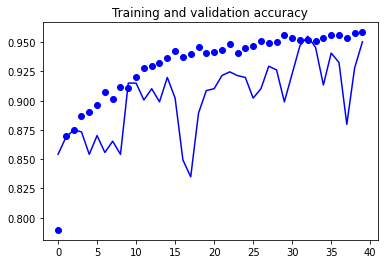

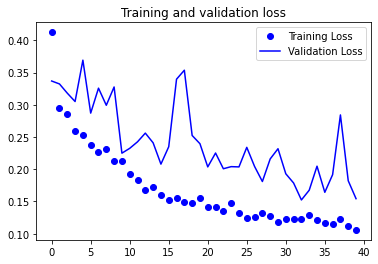

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

./CellData/chest_xray/train/NORMAL/NORMAL-133685-0001.jpeg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


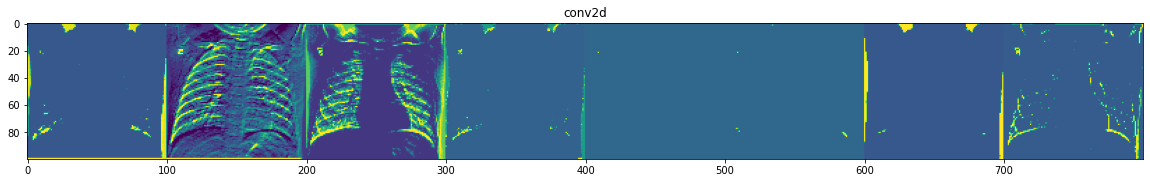

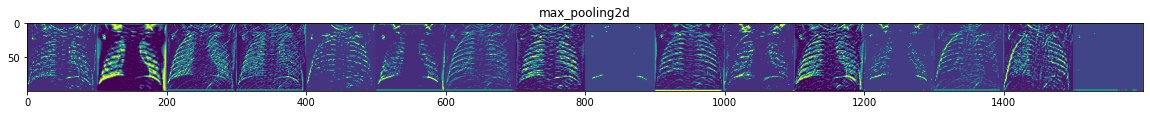

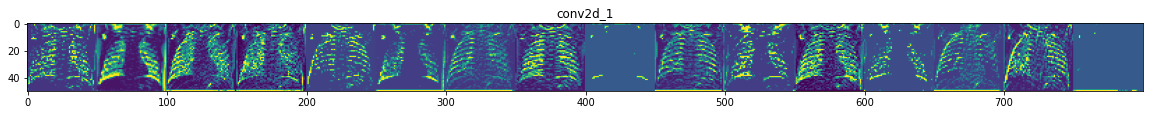

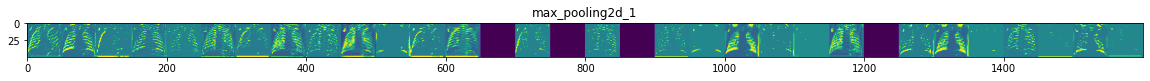

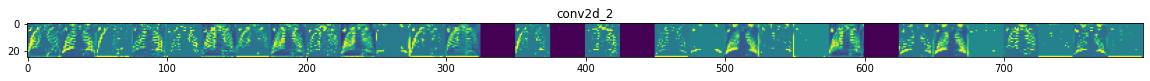

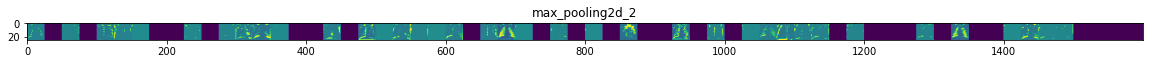

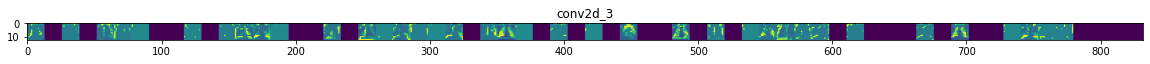

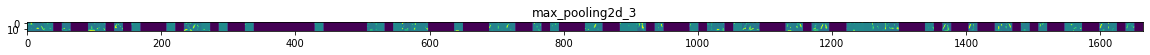

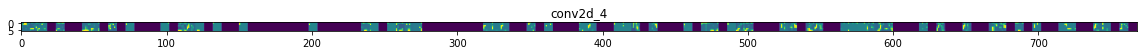

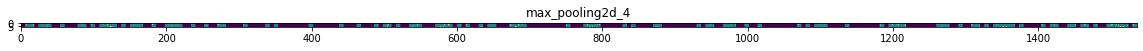

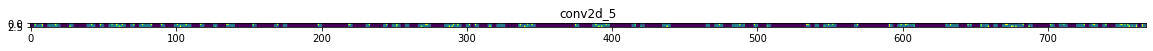

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

normal_img_files = [os.path.join(train_normal_dir, f) for f in train_normal_fnames]
pneumonia_img_files = [os.path.join(train_pneumonia_dir, f) for f in train_pneumonia_fnames]

img_path = random.choice(normal_img_files + pneumonia_img_files)
print(f"{img_path}")
img = load_img(img_path, target_size=input_shape)  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 